In [7]:
import datasets
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

import activation_functions

In [8]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 64 * 2

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print(f"Size of training data: {len(train_dataloader)}, with shape: {training_data.data.shape[0]:,} x {training_data.data.shape[1]} x {training_data.data.shape[2]}")

Size of training data: 469, with shape: 60,000 x 28 x 28


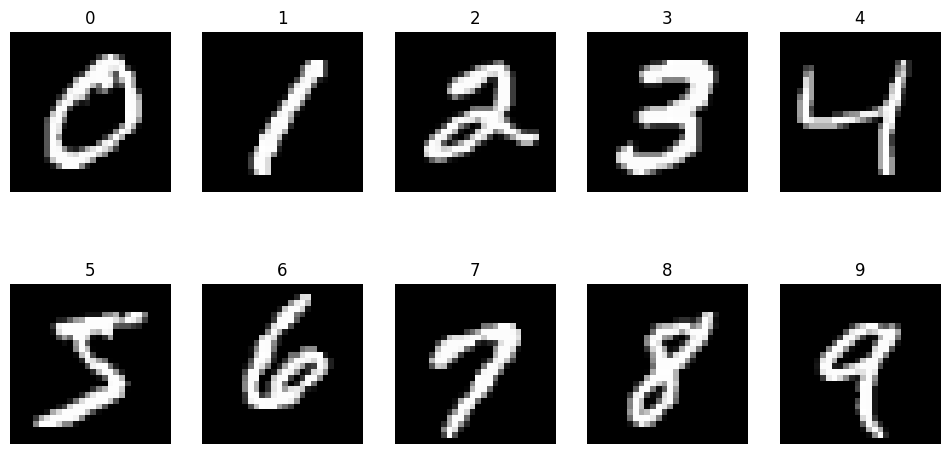

In [9]:
def find_image_with_label(label):
    id = torch.where(training_data.targets == label)[0][0]
    return training_data.data[id]

figure = plt.figure(figsize=(12, 6))
cols, rows = 5, 2
for i in range(0, cols * rows):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img = find_image_with_label(i)
    figure.add_subplot(rows, cols, i + 1)
    plt.title(i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear((10**2)*32, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = activation_functions.relu(x)
        x = self.conv2(x)
        x = activation_functions.relu(x)
        x = self.conv3(x)
        x = activation_functions.dropout(x, training=self.training)
        x = activation_functions.relu(x)
        x = self.conv4(x)
        x = activation_functions.dropout(x, training=self.training)
        x = activation_functions.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = activation_functions.log_softmax(x, dim=1)
        return x

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3200, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0:
            completed_iterations = (batch + 1) * len(X)
            correct = (pred.argmax(1) == y).sum().item()
            print(f"Accuracy: {(correct / len(y) * 100):>0.1f}%  [{completed_iterations:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")    
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

    torch.save(model, f"models/E{t+1}_Conv4_MaxPool_2NN.pt")
print("Done!")

Epoch 1
-------------------------------
Accuracy: 14.8%  [  128/60000]
Accuracy: 71.9%  [ 6528/60000]
Accuracy: 75.8%  [12928/60000]
Accuracy: 83.6%  [19328/60000]
Accuracy: 89.8%  [25728/60000]
Accuracy: 85.2%  [32128/60000]
Accuracy: 84.4%  [38528/60000]
Accuracy: 91.4%  [44928/60000]
Accuracy: 91.4%  [51328/60000]
Accuracy: 91.4%  [57728/60000]
Test Error: 
 Accuracy: 92.2%, Avg loss: 1.538803 

Epoch 2
-------------------------------
Accuracy: 92.2%  [  128/60000]
Accuracy: 96.9%  [ 6528/60000]
Accuracy: 96.1%  [12928/60000]
Accuracy: 97.7%  [19328/60000]
Accuracy: 95.3%  [25728/60000]
Accuracy: 96.1%  [32128/60000]
Accuracy: 93.0%  [38528/60000]
Accuracy: 96.1%  [44928/60000]
Accuracy: 94.5%  [51328/60000]
Accuracy: 94.5%  [57728/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 1.500512 

Done!
